# IMDb Data Processing and Analysis for Movie Keyword Modeling

## Setup: Installing and Importing Required Libraries

In [ ]:
import subprocess
import sys

# List of required packages
required_packages = [
    "imdb", "pandas", "tqdm"
]

def install_package(package):
    """Installs a package using pip if it's not already installed."""
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check and install missing packages
for package in required_packages:
    install_package(package)


All required packages are installed.


In [ ]:
from imdb import IMDb # type: ignore
import os
import pandas as pd
import json
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

## Downloading (if needed) IMDb Datasets

In [ ]:
# Define folder and file paths
dataset_folder = "Dataset"
movieInfo_path = os.path.join(dataset_folder, "title.basics.tsv.gz")
ratings_path = os.path.join(dataset_folder, "title.ratings.tsv.gz")

# Ensure the dataset folder exists
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)
    print(f"Folder '{dataset_folder}' created.")

# IMDb dataset URLs
basics_url = "https://datasets.imdbws.com/title.basics.tsv.gz"
ratings_url = "https://datasets.imdbws.com/title.ratings.tsv.gz"

# Function to download a file if it does not exist
def download_if_needed(file_path, url):
    if not os.path.exists(file_path):
        print(f"{file_path} not found. Downloading from {url}...")
        df = pd.read_csv(url, sep="\t", compression="gzip", low_memory=False)
        df.to_csv(file_path, sep="\t", compression="gzip", index=False)
        print(f"{file_path} downloaded and saved in '{dataset_folder}'.")
    else:
        print(f"{file_path} already exists in '{dataset_folder}'. Skipping download.")

# Download datasets if not already present
download_if_needed(movieInfo_path, basics_url)
download_if_needed(ratings_path, ratings_url)

Dataset\title.basics.tsv.gz already exists in 'Dataset'. Skipping download.
Dataset\title.ratings.tsv.gz already exists in 'Dataset'. Skipping download.


## Filtering and Merging IMDb Datasets

In [ ]:
# Define folder and file paths
dataset_folder = "Dataset"
title_basics_path = os.path.join(dataset_folder, "title.basics.tsv.gz")
ratings_path = os.path.join(dataset_folder, "title.ratings.tsv.gz")
output_path = os.path.join(dataset_folder, "movies_Info.csv")

# Load the datasets
print("Loading datasets...")
title_basics = pd.read_csv(title_basics_path, sep="\t", compression="gzip", low_memory=False)
title_ratings = pd.read_csv(ratings_path, sep="\t", compression="gzip", low_memory=False)

# Filter for movies
print("Filtering for movies...")
movies_only = title_basics[title_basics["titleType"].isin({"movie"})]

# Merge basics and ratings datasets
print("Merging datasets...")
merged_movies = pd.merge(movies_only, title_ratings, on="tconst", how="left")

# Handle missing ratings by setting them to None
merged_movies["averageRating"] = merged_movies["averageRating"].where(merged_movies["averageRating"].notna(), None)

# If averageRating is None, ensure numVotes is also None
merged_movies.loc[merged_movies["averageRating"].isna(), "numVotes"] = None

# Select required columns and rename them
movies_dataset = merged_movies[["tconst", "primaryTitle", "startYear", "runtimeMinutes", "genres", "averageRating", "numVotes"]].copy()

movies_dataset.rename(columns={
    "tconst": "MovieID",
    "primaryTitle": "Title",
    "startYear": "Year",
    "runtimeMinutes": "Duration",
    "genres": "Genres",
    "averageRating": "Rating",
    "numVotes": "NumVotes"
}, inplace=True)

# Filter datasets further
movies_with_ratings = movies_dataset[movies_dataset["Rating"].notna()]
movies_with_genres = movies_dataset[movies_dataset["Genres"] != "\\N"]
final_dataset = movies_with_ratings[movies_with_ratings["Genres"] != "\\N"]
#final_dataset.loc[:, "Reviews"] = None

# Save the final dataset to CSV
final_dataset.to_csv(output_path, index=False)
print(f"Final dataset saved to '{output_path}'.")

# Print the total number of titles in the final dataset
print(f"Total number of titles in final dataset: {len(final_dataset)}")

Loading datasets...
Filtering for movies...
Merging datasets...
Final dataset saved to 'Dataset\movies_Info.csv'.
Total number of titles in final dataset: 312661


In [ ]:
import pickle

# Specify the path where you want to save the file
file_path = "C:/Users/aless/Desktop/DNLP_Project/final_dataset.pkl"

# Save the dataset
with open(file_path, 'wb') as file:
    pickle.dump(final_dataset, file)

print(f"final_dataset has been saved to {file_path}.")


final_dataset has been saved to C:/Users/aless/Desktop/DNLP_Project/final_dataset.pkl.


### Exploratory Data Analysis of the Datasets

In [ ]:
# DATABASE ANALYSIS
print("\nDATABASE ANALYSIS")

# Total titles in the IMDb database (from title.basics)
total_titles_imdb = len(title_basics)
print("\n=== IMDb Database (title.basics) ===")
print(f"Total number of titles in the IMDb database: {total_titles_imdb}")

# Titles that are NOT movies
non_movies_imdb = len(title_basics[~title_basics["titleType"].isin({"movie"})])
print(f"   - Number of titles that are NOT movies: {non_movies_imdb}")

# Movies in the IMDb database
movies_imdb = len(movies_only)
print(f"   - Number of movies in the IMDb database: {movies_imdb}")

# Titles with ratings (from title.ratings)
print("\n=== IMDb Ratings Data (title.ratings) ===")
total_titles_with_ratings = len(title_ratings)
print(f"Total number of titles with ratings available: {total_titles_with_ratings}")

# Movies without ratings
movies_without_ratings_count = len(movies_dataset[movies_dataset["Rating"].isna()])

# Movies with ratings
movies_with_ratings_count = len(movies_with_ratings)

# Movies without genres
movies_without_genres_count = len(movies_dataset[movies_dataset["Genres"] == "\\N"])

# Movies with both ratings and genres (final dataset)
final_movies_count = len(final_dataset)

# Total number of elements included in the final dataset
total_elements_merged_dataset = len(merged_movies)
print("\n=== Final Dataset ===")
print(f"Total number of movies included in the merged dataset: {total_elements_merged_dataset}")
print(f"   - Movies without ratings: {movies_without_ratings_count}")
print(f"   - Movies with ratings: {movies_with_ratings_count}")
print(f"   - Movies without genres: {movies_without_genres_count}")
print(f"   - Movies with ratings and genres (final dataset): {final_movies_count}")

print(f"\nSo, in the end, the final dataset contains {final_movies_count} movies")


DATABASE ANALYSIS

=== IMDb Database (title.basics) ===
Total number of titles in the IMDb database: 11374541
   - Number of titles that are NOT movies: 10671664
   - Number of movies in the IMDb database: 702877

=== IMDb Ratings Data (title.ratings) ===
Total number of titles with ratings available: 1522441

=== Final Dataset ===
Total number of movies included in the merged dataset: 702877
   - Movies without ratings: 379415
   - Movies with ratings: 323462
   - Movies without genres: 75991
   - Movies with ratings and genres (final dataset): 312661

So, in the end, the final dataset contains 312661 movies


In [ ]:
from collections import Counter

# Supponiamo che unique_genres sia il set con i generi unici e 'Genres' sia la colonna del DataFrame
genre_counts = Counter()

# Conta le occorrenze di ogni genere
for genres in final_dataset['Genres'].dropna():
    for genre in genres.split(','):
        genre_counts[genre.strip()] += 1

# Mostra il risultato
print(genre_counts)


Counter({'Drama': 144356, 'Comedy': 78215, 'Documentary': 51439, 'Romance': 35580, 'Action': 32938, 'Crime': 27898, 'Thriller': 27178, 'Horror': 24553, 'Adventure': 19573, 'Mystery': 12828, 'Family': 12390, 'Biography': 10137, 'Fantasy': 9754, 'History': 9082, 'Music': 8063, 'Sci-Fi': 7638, 'Musical': 6831, 'War': 6546, 'Animation': 5671, 'Western': 5374, 'Adult': 4420, 'Sport': 4050, 'Film-Noir': 867, 'News': 678, 'Reality-TV': 86, 'Talk-Show': 28, 'Game-Show': 9})


In [ ]:

# Supponiamo che unique_genres sia il set con i generi unici e 'Genres' sia la colonna del DataFrame
from collections import Counter

genre_counts_new = Counter()

# Verifica se la colonna 'Genres' esiste nel dataset
if 'Genres' in final_dataset.columns:
    # Conta le occorrenze di ogni genere solo se c'è un genere unico
    for genres in final_dataset['Genres'].dropna():
        if ',' not in genres:  # Controlla che non ci siano virgole
            genre_counts_new[genres.strip()] += 1

    # Mostra il risultato
    print(genre_counts_new)
else:
    print("La colonna 'Genres' non esiste nel dataset.")


Counter({'Drama': 55001, 'Documentary': 34854, 'Comedy': 26173, 'Horror': 7841, 'Thriller': 4992, 'Action': 4620, 'Romance': 3080, 'Adult': 2650, 'Western': 2506, 'Adventure': 1781, 'Crime': 1719, 'Family': 1662, 'Animation': 1012, 'Sci-Fi': 981, 'Musical': 920, 'Mystery': 744, 'Fantasy': 682, 'Music': 670, 'War': 533, 'Biography': 487, 'History': 370, 'Sport': 239, 'Reality-TV': 36, 'Talk-Show': 11, 'News': 8, 'Game-Show': 3})


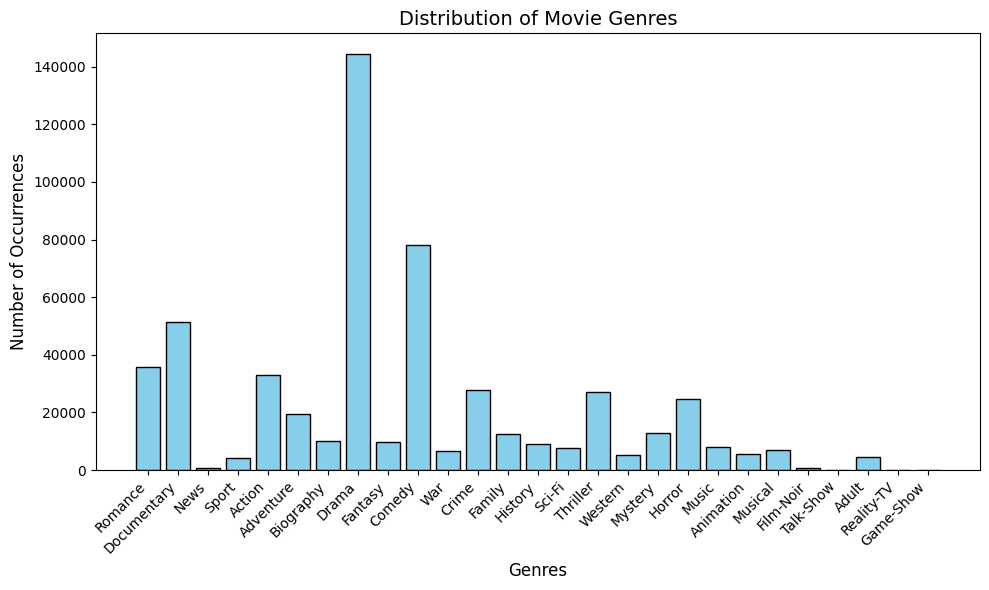

In [ ]:
import matplotlib.pyplot as plt

# Convert the Counter into two lists: genres and counts
genres = list(genre_counts.keys())
counts = list(genre_counts.values())

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(genres, counts, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.title('Distribution of Movie Genres', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels for better readability

# Display the histogram
plt.tight_layout()
plt.show()


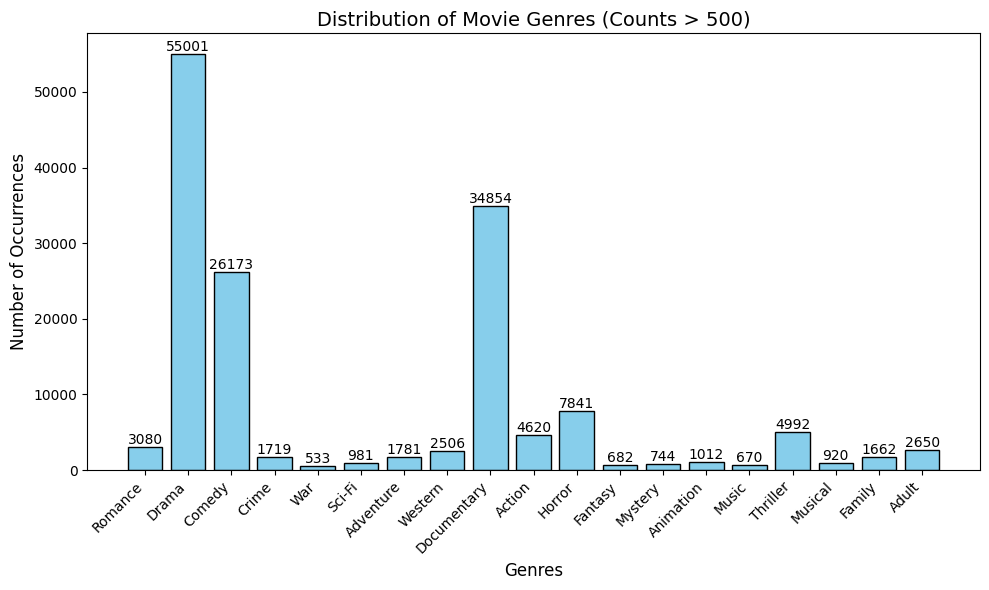

In [ ]:
import matplotlib.pyplot as plt

# Filter genres and counts for values greater than 500
filtered_genres = [genre for genre, count in genre_counts_new.items() if count > 500]
filtered_counts = [count for count in genre_counts_new.values() if count > 500]

# Create the histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(filtered_genres, filtered_counts, color='skyblue', edgecolor='black')

# Add numbers above each bar
for bar in bars:
    height = bar.get_height()  # Get the height of each bar
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5,  # Position the text
             str(int(height)), ha='center', va='bottom', fontsize=10)

# Add labels and title
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.title('Distribution of Movie Genres (Counts > 500)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels for better readability

# Display the histogram
plt.tight_layout()
plt.show()



In [ ]:
#display(final_dataset[final_dataset['Genres'].str.contains('Film-Noir', case=False, na=False)])

display(final_dataset[(final_dataset['Genres'] == 'Western') & (final_dataset['NumVotes'] >= 200)])

,MovieID,Title,Year,Duration,Genres,Rating,NumVotes
391,tt0003657,The Bargain,1914,70,Western,6.5,262.0
787,tt0004766,The Virginian,1914,55,Western,5.6,265.0
1802,tt0006753,The Half-Breed,1916,73,Western,6.7,237.0
2431,tt0007755,Bucking Broadway,1917,53,Western,6.1,711.0
3456,tt0009153,Hell Bent,1918,53,Western,6.0,463.0
...,...,...,...,...,...,...,...
658986,tt7605084,A Reckoning,2018,80,Western,3.5,250.0
673121,tt8290068,To Hell and Gone,2019,82,Western,5.9,334.0
687284,tt9021234,The Legend of 5 Mile Cave,2019,90,Western,6.2,1066.0
689737,tt9135272,Eminence Hill,2019,100,Western,4.4,664.0


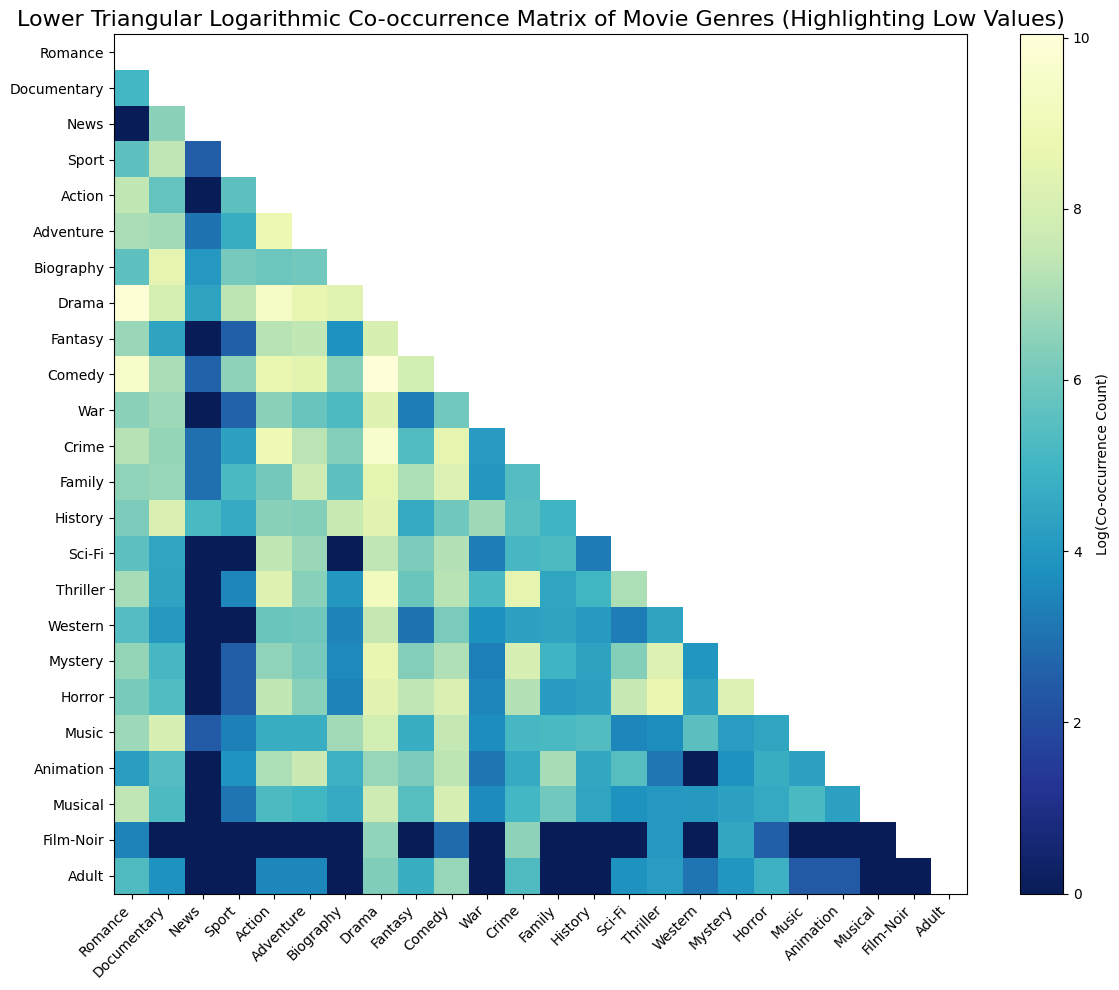

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

# Step 1: Estrazione dei generi e conteggio delle loro occorrenze
co_occurrence_counts = Counter()
genre_counts = Counter()

# Conta le occorrenze di ogni genere
for genres in final_dataset['Genres'].dropna():
    genre_list = [g.strip() for g in genres.split(',')]
    for genre in genre_list:
        genre_counts[genre] += 1  # Conta il numero di film per ogni genere
    for pair in combinations(genre_list, 2):
        co_occurrence_counts[tuple(sorted(pair))] += 1

# Step 2: Filtrare i generi con almeno 499 occorrenze
valid_genres = [genre for genre, count in genre_counts.items() if count >= 499]

# Step 3: Creare una matrice di co-occorrenza solo per i generi validi
co_occurrence_matrix = pd.DataFrame(0, index=valid_genres, columns=valid_genres)

for (g1, g2), count in co_occurrence_counts.items():
    if g1 in valid_genres and g2 in valid_genres:
        co_occurrence_matrix.loc[g1, g2] = count
        co_occurrence_matrix.loc[g2, g1] = count  # Poiché è simmetrico

# Step 4: Mascherare la parte superiore della matrice
mask = np.triu(np.ones_like(co_occurrence_matrix, dtype=bool))

# Sostituire i valori della parte superiore con NaN per mascherarli
co_occurrence_matrix_masked = co_occurrence_matrix.where(~mask)

# Step 5: Impostare a zero i valori inferiori a 10
co_occurrence_matrix_masked[co_occurrence_matrix_masked < 10] = 0

# Step 6: Applicare la scala logaritmica
log_co_occurrence_matrix_masked = np.log1p(co_occurrence_matrix_masked)

# Step 7: Creare una heatmap con Matplotlib
plt.figure(figsize=(12, 10))
plt.imshow(log_co_occurrence_matrix_masked, cmap='YlGnBu_r', aspect='auto')  # Invertire la colormap

# Aggiungere le etichette degli assi
plt.xticks(np.arange(len(valid_genres)), valid_genres, rotation=45, ha='right')
plt.yticks(np.arange(len(valid_genres)), valid_genres)

# Aggiungere una barra dei colori
plt.colorbar(label='Log(Co-occurrence Count)')

# Aggiungere un titolo
plt.title('Lower Triangular Logarithmic Co-occurrence Matrix of Movie Genres (Highlighting Low Values)', fontsize=16)

# Mostrare la heatmap
plt.tight_layout()
plt.show()


In [ ]:
display(co_occurrence_matrix)

,Romance,Documentary,News,Sport,Action,Adventure,Biography,Drama,Fantasy,Comedy,...,Sci-Fi,Thriller,Western,Mystery,Horror,Music,Animation,Musical,Film-Noir,Adult
Romance,0,162,3,277,1707,1146,274,21148,819,13434,...,281,1037,225,773,460,897,67,1628,30,201
Documentary,162,0,662,1632,315,978,5138,2928,82,1136,...,84,81,56,170,211,3143,226,198,0,44
News,3,662,0,11,2,20,54,80,0,13,...,0,3,0,2,1,10,4,0,0,0
Sport,277,1632,11,0,268,118,442,1547,12,683,...,9,32,3,11,11,28,48,21,9,9
Action,1707,315,2,268,0,6725,364,12296,1461,5846,...,1713,4223,357,724,1691,118,1197,197,9,34
Adventure,1146,978,20,118,6725,0,405,5657,1705,4636,...,821,607,376,451,605,115,2172,153,7,34
Biography,274,5138,54,442,364,405,0,4369,44,613,...,9,52,31,35,30,979,132,104,2,8
Drama,21148,2928,80,1547,12296,5657,4369,0,3237,22879,...,1644,9858,1742,5790,4508,2829,786,2311,747,536
Fantasy,819,82,0,12,1461,1705,44,3237,0,2855,...,490,354,20,551,1612,116,499,240,1,114
Comedy,13434,1136,13,683,5846,4636,613,22879,2855,0,...,1347,1468,487,1295,3553,1785,1535,3196,16,798
